# Linear Regression to approximate nonlinear functions

Nicolas Oulianov

## Introduction

The linear regression model is a method to approximate coefficients of linear functions. That is, in function that, in 1D, look like $f(x) = ax + b$, find the best $a$ and $b$. Here, $x$ is the data collected, and $f(x)$ what's to be predicted. 

In $n$ dimension, the previous equation is equivalent to this one $f(x) = <a, x> + b$, where $f(x), b \in \mathbb{R}$, and $a, x \in \mathbb{R^n}$

Now, what if $f(x)$ isn't a function as simple as above ? **What if the function isn't linear ?**

Well, in several cases, **linear regression can still be used to approximate its parameters.** 

In this notebook, I'll present some handy methods I've collected that deal with common tricky cases.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
sns.set(style="darkgrid")

## 1. Polynomials

Polynomials equations look like that : 

$$\forall x \in \mathbb{R}, f(x) = \sum_{i=0}^{n}a_ix^i$$

Fortunately, they can be rewriten as a standard linear equation, assuming $x$ is fixed. 

Let $x \in \mathbb{R}$ fixed.

Let's denote $X = (x_1, \dots, x_n) \in \mathbb{R}^n$, where $\forall i \in \{ 1, \dots, n \} , x_i = x^i$

Then $f(x) = f(X) = <a, X> + b$, which is a linear equation that is easily solvable. 

Now, let's see how it looks with code on a simple $n=3$ case. 

In [2]:
# Number of observations
n = 200

# features vector
x = np.linspace(0, 10, n)

# f(x), the values we try to predict
a, b, c, d = 40, 10, -1.5, 0.4
f_x = a + b*x + c*x**2 + d*x**3

# Add gaussian noise to the data.
f_x_noisy = f_x + (np.random.randn(n)*15)

# Estimate a, b, c, d using linear regression
model = LinearRegression()

# Transformation
def add_n_powers(x, n):
    X = []
    for i in range(1, n+1):
        X.append(x**i)
    return np.array(X).T

X = add_n_powers(x, 3)
model.fit(X, f_x_noisy)
f_x_estimated = model.predict(X)

# Plotting
def visualisation():
    fig = plt.figure(figsize=(10, 8)) # change figsize
    sns.lineplot(x, f_x, color="red")
    sns.scatterplot(x, f_x_noisy)
    sns.lineplot(x, f_x_estimated, color="cyan")
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.legend(['true f(x)', 'estimated f(x)', 'noisy f(x) values'])
    plt.show()

Now, let's compare the true coefficients with those estimated. 

In [3]:
results = pd.DataFrame()
results['Real value'] = [a,b,c,d]
results['Estimated value'] = [model.intercept_] + list(model.coef_)
results['% Difference'] = 100*(results['Estimated value'] - results['Real value'])/results['Real value']

print('Estimation risk :', np.var(model.predict(X) - f_x))

print('Coefficient values error :')
results

Estimation risk : 0.3207392284213273
Coefficient values error :


,Real value,Estimated value,% Difference
0,40.0,42.198661,5.496652
1,10.0,9.983702,-0.162979
2,-1.5,-1.587046,5.803034
3,0.4,0.410348,2.587041


Even if the coefficient values aren't exactly the same, the estimation risk is very low. Indeed, even if the exact coefficients values haven't been found, the true curve has been approximated very well. This can be seen on the plot above. 

Beware ! One can be tempted to add many powers of x, in order to try to lower the estimation risk. But this approach will ultimately overfit the data and make the model uninterpretable. 

Look at the example below that shows what _not_ to do. 

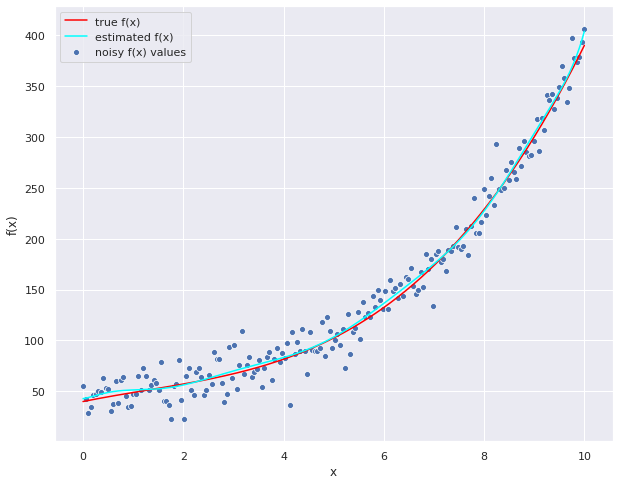

In [4]:
# Estimate a, b, c, d using linear regression
model = LinearRegression()

# Transformation
def add_n_powers(x, n):
    X = []
    for i in range(1, n+1):
        X.append(x**i)
    return np.array(X).T

X = add_n_powers(x, 10)
model.fit(X, f_x_noisy)
f_x_estimated = model.predict(X)

visualisation()

In [5]:
results = pd.DataFrame()
results['Real value'] = np.zeros(11)
results['Real value'].iloc[0:4] = [a,b,c,d]
results['Estimated value'] = [model.intercept_] + list(model.coef_)
results['% Difference'] = 100*(results['Estimated value'] - results['Real value'])/results['Real value']

print('Estimation risk :', np.var(f_x_estimated - f_x))

print('Coefficient values error :')
results

Estimation risk : 4.232407006046298
Coefficient values error :


,Real value,Estimated value,% Difference
0,40.0,42.825899,7.064746e+00
1,10.0,8.071771,-1.928229e+01
2,-1.5,29.993328,-2.099555e+03
3,0.4,-66.113124,-1.662828e+04
4,0.0,55.532147,inf
5,0.0,-24.202513,-inf
6,0.0,6.129811,inf
7,0.0,-0.935870,-inf
8,0.0,0.084921,inf
9,0.0,-0.004218,-inf


Even though the curves look very similar, the estimated coefficients are very different from the real ones.  

In case of doubt, as a rule of thumb, prefer a simpler polynomial.

## 2. Ratios

Let's consider other kinds of function that involve ratios. These are mostly common in business and marketing. The simplest example can be :

$$\forall x, y \in \mathbb{R}, f(x, y) = a + bx + c\frac{y}{x}$$

Let's take an example. $f(x)$ could be the value of a customer sale, $x$ could be the number of articles bought, and $\frac{y}{x}$ the average marketing expenses for bought products. By finding the coefficients of this equation, you try to understand customer behaviour. How much are marketing expenses positively impacting sales ? 

This function is not linear. But, with fixed $x$ and $y$, one can be tempted to perform a transformation similar to the one above, and to state

Let $X=(x1, x2) \in \mathbb{R}^2$, such as $x_1 = x$ and $x_2 = \frac{y}{x}$

We have then $f(x,y) = f(X) = a + <\beta, X>$ which is a linear equation.

Let's try that. 

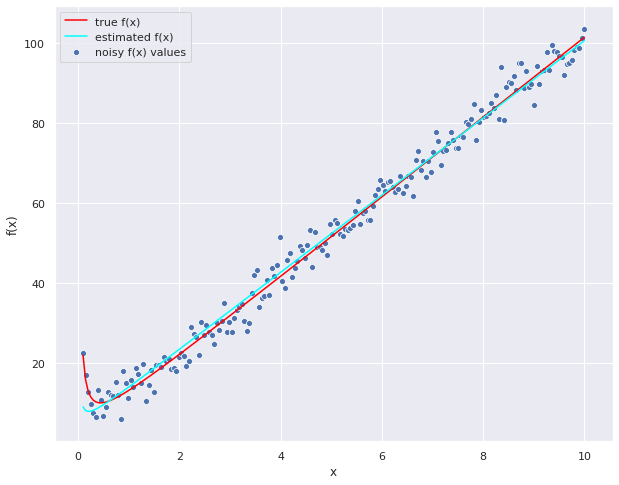

In [302]:
# Number of observations
n = 200

# features vectors
x = np.linspace(0.1, 10, n) 
y = np.linspace(1, 2, n)

# f(x), the values we try to predict
a, b, c = 1, 10, 2
f_x = a + b*x + c*y/x

# Add gaussian noise to the data.
x_noisy = x + np.random.randn(n)*0.4
f_x_noisy = f_x + (np.random.randn(n)*3)

# Estimate a, b, c, d using linear regression
model = LinearRegression()

# Transformation
X = np.array([x, y/x]).T
X_noisy = np.array([x_noisy, y/x_noisy]).T
model.fit(X_noisy, f_x_noisy)
f_x_estimated = model.predict(X)

# Plotting
# We plot only according to the x axis. 
visualisation()

In [303]:
results = pd.DataFrame()
results['Real value'] = [a,b,c]
results['Estimated value'] = [model.intercept_] + list(model.coef_)
results['% Difference'] = 100*(results['Estimated value'] - results['Real value'])/results['Real value']

print('Estimation risk :', np.var(model.predict(X) - f_x))

print('Coefficient values error :')
results

Estimation risk : 1.9323557881886304
Coefficient values error :


,Real value,Estimated value,% Difference
0,1,3.896194,289.619363
1,10,9.659031,-3.409691
2,2,0.423798,-78.810096


The results are not _too_ bad risk-wise, but the coefficient estimation is pretty bad. And, as soon as the $c$ coefficient is too small compared to $b$, then the model yields very bad values. 

This is due to the fact that $\frac{1}{x}$ is much, much smaller than $x$, especially for large values of x. Thus, for the model tend to consider $\frac{1}{x}$ as noise.

A possible solution to find a more accurate $c$ coefficient is to perform another transformation. Given fixed $x, y \in \mathbb{R}$, 

Let $g(x, y) = xf(x,y) = ax + bx^2 + cy$

Let $X \in \mathbb{R}^3 = (x, x^2, y)$

Thus, $g(x, y) = <beta, X>$ which is a linear equation. 

Now, using this last transformation, perform a linear regression on $g(x, y)$ to find $a, b,$ and $c$. Notice that the coefficients found this way are still the same that those of $f$.

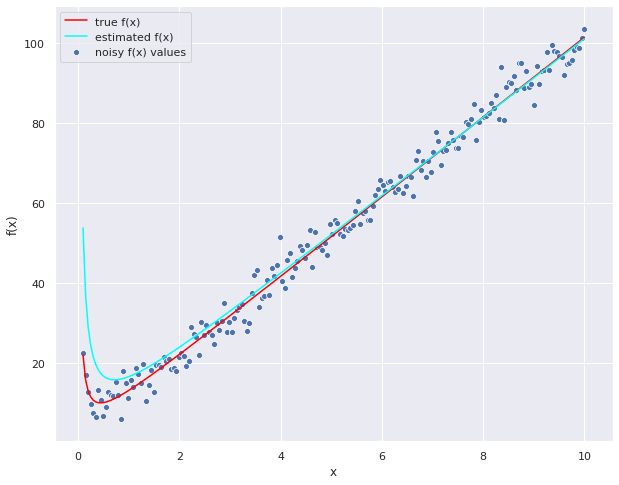

In [304]:
# Estimate a, b, c, d using linear regression
model_2 = LinearRegression(fit_intercept=False)

# Transformation
f_x_transform = f_x_noisy*x_noisy
X = np.array([x, x**2, y]).T
X_noisy = np.array([x_noisy, x_noisy**2, y]).T
model_2.fit(X_noisy, f_x_transform)
f_x_estimated = model_2.predict(X)/x

# Plotting
# We plot only according to the x axis. 
visualisation()

In [305]:
results = pd.DataFrame()
results['Real value'] = [a,b,c]
results['Estimated value'] = model_2.coef_
results['% Difference'] = 100*(results['Estimated value'] - results['Real value'])/results['Real value']

print('Estimation risk :', np.var(f_x_estimated - f_x))

print('Coefficient values error :')
results

Estimation risk : 11.380563663197158
Coefficient values error :


,Real value,Estimated value,% Difference
0,1,1.107667,10.766747
1,10,9.892185,-1.078152
2,2,5.170225,158.511227


Here, using this last transformation, the estimation risk is sometimes lower. However, the coefficients' values are also higher, especially the one in front of $\frac{1}{x}$. 

This transformation does not always perform better than the first one. **Most of the time, it performs worse !**

It depends on the $x$ and $y$ data range, and also the noise level. In a production setting, it's best to try with both approaches and take the time to understand $f$, what's to be modeled, better. 

## 3. Bass model

This model is notably used in sales growth prediction. The resulting curve are S-shaped. 

This usage of linear regression is slightly different. Indeed, we use it as a way to estimate parameters of a differential equation. The model is as follows : 

Given a time series $x_1, \dots, x_n \in \mathbb{R}^n$, define $f$ such as

$$\forall i \in \{1, \dots, n\}, f(x_i) = (p + \frac{q}{m}N(x_{i-1}))(m - N(x_{i-1})) $$

Where 

- $N(x_i) = \sum_{k=0}^{n} f(x_k)$
- $p \in [0;1]$ is the coefficient of innovation
- $q \in [0;1]$ is the coefficient of imitation
- $m>0$ is the maximum market size

The previous equation can be written as

$$\forall i \in \{1, \dots, n\}, f(x_i) = a + bN(x_{i-1})  + cN(x_{i-1})^2$$

with $a = pm, b = q-p, c = \frac{-q}{m}$. This last function is a polynomial, to which the same transformation as seen in **1. Polynomials** can be applied. 

However, the $a, b, c$ obtained with this linear regression aren't directly our parameters of interest. You need to apply the inverse transform to find back $p, q, m$. One can eventualy find that :

- $m = \frac{-b \pm \sqrt{b^2 - 4ac}}{2c}$ (NB : There are thus two $m$ possible. Chosing the one used for modelization has to be done according to 1. the condition $m>0$, and 2. real business considerations) 
- $p = \frac{a}{m}$
- $q = -mc$

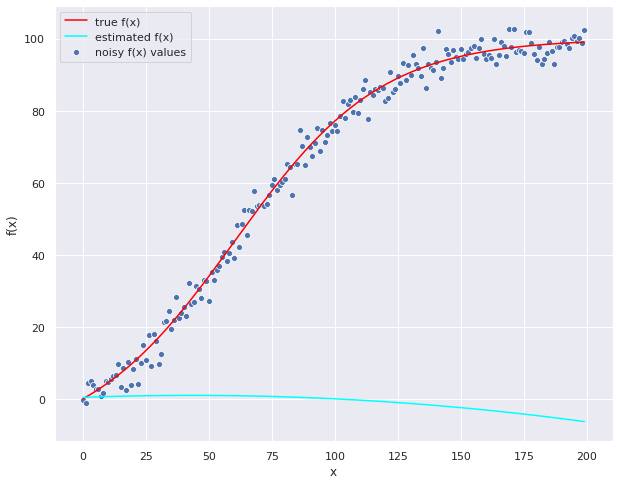

In [342]:
# Generate the data
x = np.array(list(range(n)))
df_x = np.zeros(n)
df_x[0] = 0
p, q, m = 0.004, 0.03, 100

for i in range(1, n):
    N_i = np.cumsum(df_x)[-1]
    df_x[i] = (p + (q/m)*N_i)*(m - N_i)
    
f_x = np.cumsum(df_x)

# We now try to approximate f_x using only the first few values.
f_x_noisy = f_x + np.random.randn(n)*3
train = f_x[0:int(n/10)]

dtrain = train - np.roll(train, 1)

x_train = train[0:-2]
X = np.array([x_train, x_train**2]).T
y = dtrain[1:-1]

model = LinearRegression()
model.fit(X, y)

X = np.array([x, x**2]).T
f_x_estimated = model.predict(X)


fig = plt.figure(figsize=(10, 8)) # change figsize
sns.lineplot(x, f_x, color="red")
sns.scatterplot(x, f_x_noisy)
sns.lineplot(x, f_x_estimated, color="cyan")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['true f(x)', 'estimated f(x)', 'noisy f(x) values'])
plt.show()

## Log transform

$$\forall x, y \in \mathbb{R}^n, f(x, y) = \frac{\prod_{i=1}^{n}x_i}{\prod_{i=1}^{n}y_i} $$

In [343]:
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18